# Part 1: Uploading, Querying and Visualizing Images

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
from src.utils.image_plotting import show_images_from_df, show_similar_images
from getpass import getpass
from copy import copy

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# Creating Snowpark Session
sf_connection = {
    "account": "sfseeurope-prod_demo_gorkow",
    "user": getpass(),
    "password": getpass(),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH"
}
session = Session.builder.configs(sf_connection).create()

In [3]:
# Create a new database
session.sql('CREATE OR REPLACE DATABASE IMAGES').collect()

# Create a Snowflake Stage and enable the Directory Table
session.sql("""CREATE OR REPLACE STAGE IMAGE_FILES
                DIRECTORY = (ENABLE = TRUE AUTO_REFRESH = FALSE) 
                ENCRYPTION = (TYPE = 'SNOWFLAKE_SSE') 
                COMMENT='Stage to store Image Files'""").collect()

# Upload JPG-Files from a local folder to the Snowflake Stage
session.file.put(local_file_name='../resources/image_files/*.jpg',
                 stage_location='@IMAGE_FILES', 
                 auto_compress=False, 
                 overwrite=True)

# Update the Directory Table (can be automated via Snowflake Tasks)
session.sql('ALTER STAGE IMAGE_FILES REFRESH').collect()

[Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image4.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image5.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image3.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image6.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image1.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image2.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-3110-4ec3-8da7-bddfee8b109c/image8.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/55fc883d-

In [4]:
# Create a Snowpark DataFrame for the Directory Table
image_df = session.sql("SELECT * FROM DIRECTORY(@IMAGE_FILES)")
image_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"  |"SIZE"  |"LAST_MODIFIED"            |"MD5"                             |"ETAG"                            |"FILE_URL"                                          |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|image1.jpg       |378517  |2023-06-14 02:07:41-07:00  |633c962e26413335b19c2c1defa19e84  |633c962e26413335b19c2c1defa19e84  |https://job14991.snowflakecomputing.com/api/fil...  |
|image2.jpg       |378517  |2023-06-14 02:07:41-07:00  |633c962e26413335b19c2c1defa19e84  |633c962e26413335b19c2c1defa19e84  |https://job14991.snowflakecomputing.com/api/fil...  |
|image3.jpg       |343635  |2023-06-14 02:07:39-07:00  |52a979e11ff5b06bdec9011688d1dcee  |52a979e11

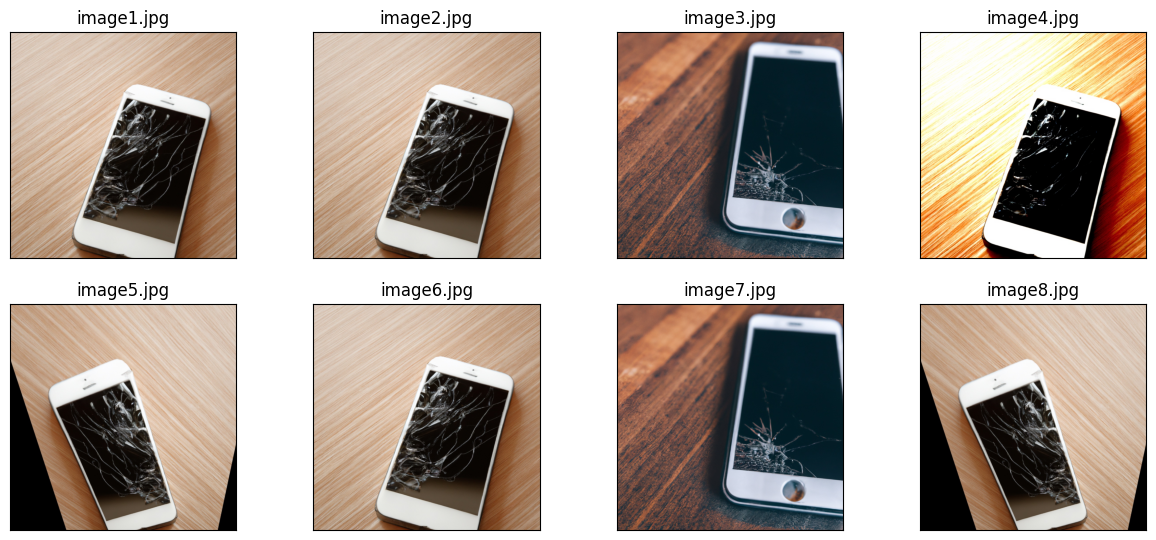

In [5]:
show_images_from_df(image_df, stage='@IMAGE_FILES', ncol=4, figsize=(15,10))

In [6]:
# Counts per MD5
md5_counts = image_df.group_by(['MD5']).agg(F.count('MD5').as_('COUNT')).where(F.col('COUNT') > 1)

# Join duplicates with original dataframe
images_with_same_md5 = image_df.join(md5_counts, on=['MD5']).order_by(['MD5','COUNT'])
images_with_same_md5 = images_with_same_md5.join(copy(images_with_same_md5), on=['MD5'], lsuffix='_LEFT', rsuffix='_RIGHT')

# Remove rows where left/right image are the same
images_with_same_md5 = images_with_same_md5.filter(F.col('RELATIVE_PATH_LEFT') != F.col('RELATIVE_PATH_RIGHT'))
images_with_same_md5 = images_with_same_md5.order_by('RELATIVE_PATH_LEFT','RELATIVE_PATH_RIGHT')
images_with_same_md5['RELATIVE_PATH_LEFT','RELATIVE_PATH_RIGHT'].show()

------------------------------------------------
|"RELATIVE_PATH_LEFT"  |"RELATIVE_PATH_RIGHT"  |
------------------------------------------------
|image1.jpg            |image2.jpg             |
|image1.jpg            |image6.jpg             |
|image2.jpg            |image1.jpg             |
|image2.jpg            |image6.jpg             |
|image3.jpg            |image7.jpg             |
|image5.jpg            |image8.jpg             |
|image6.jpg            |image1.jpg             |
|image6.jpg            |image2.jpg             |
|image7.jpg            |image3.jpg             |
|image8.jpg            |image5.jpg             |
------------------------------------------------



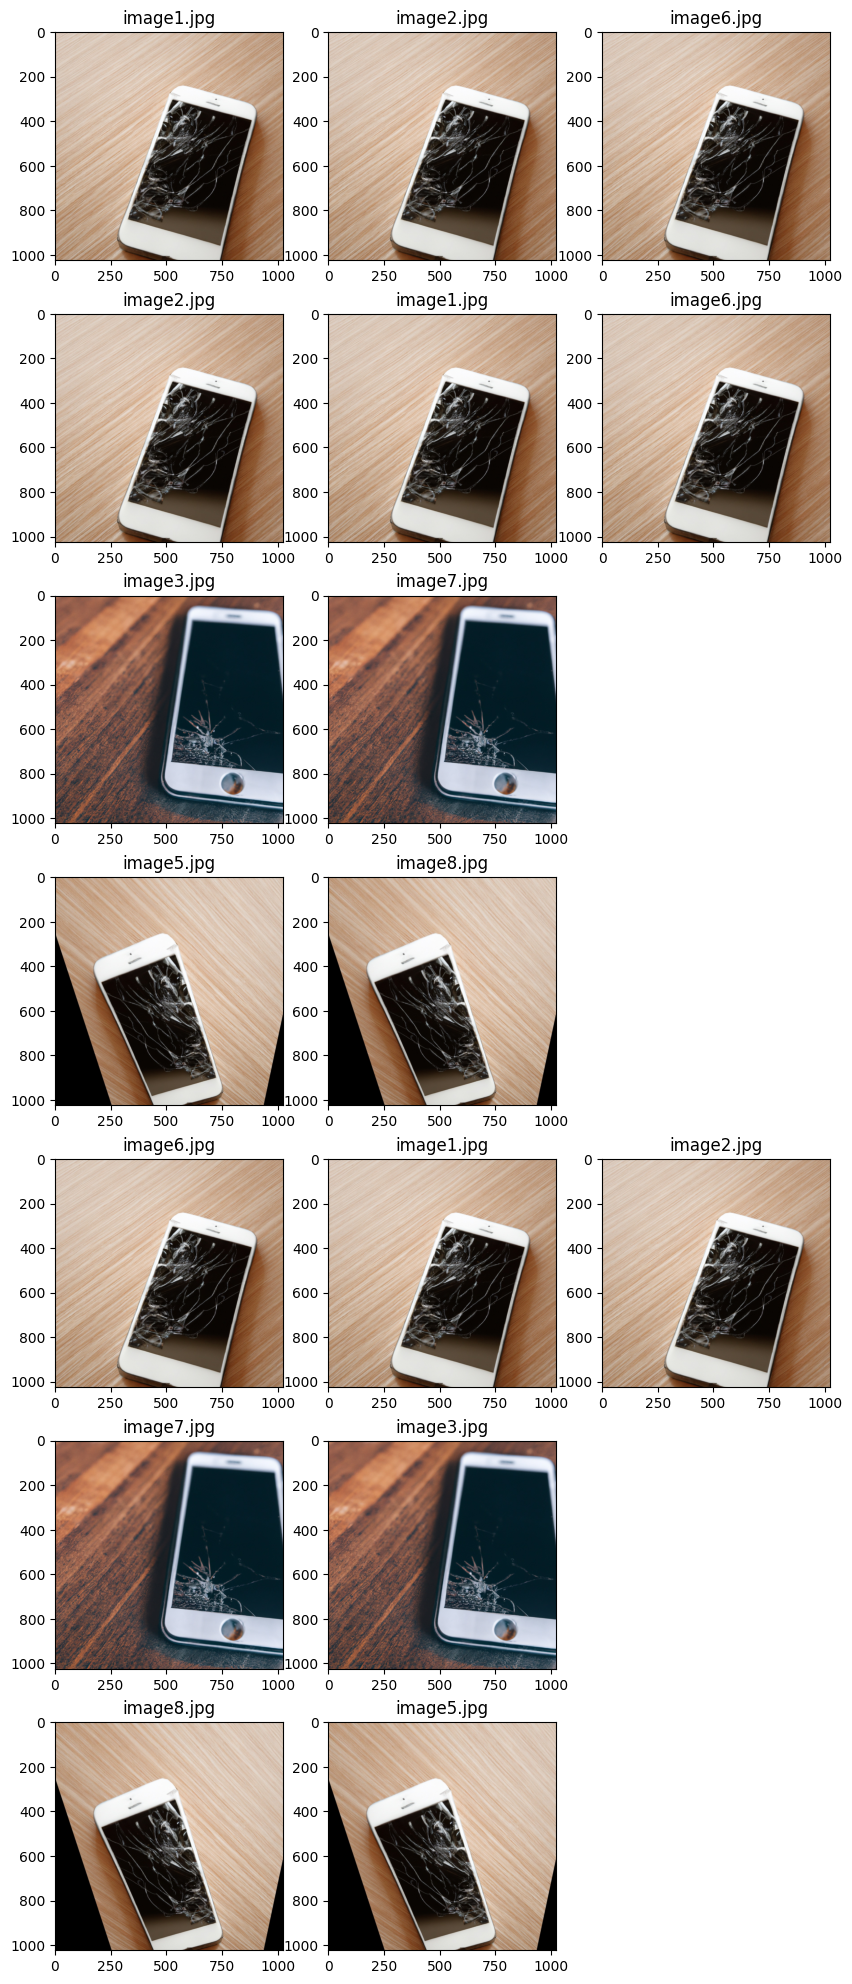

In [7]:
show_similar_images(df=images_with_same_md5, stage='@IMAGE_FILES', figsize=(10,25))